### Biblioteca utilizadas

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
# Configuração do pandas para apresentar no máximo 15 linhas de um dataframe
pd.set_option('display.max_rows',15)

# Configuração do pandas para apresentar no máximo 15 colunas de um dataframe
pd.set_option('display.max_columns',15)

### Importando dados

In [3]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

df_dados = pd.read_csv(uri)

In [4]:
df_dados.head()

,Unnamed: 0,preco,vendido,idade_do_modelo,km_por_ano
0,0,30941.02,1,18,35085.22134
1,1,40557.96,1,20,12622.05362
2,2,89627.50,0,12,11440.79806
3,3,95276.14,0,3,43167.32682
4,4,117384.68,1,4,12770.11290


In [5]:
df_dados.drop(columns='Unnamed: 0', inplace=True)

In [6]:
df_dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


### Dividindo entre dados de treinamento e teste

In [7]:
X = df_dados[['preco', 'idade_do_modelo', 'km_por_ano']]
y = df_dados.vendido

In [8]:
SEED = 158020
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

print(f'Quantidade de registro para treino - {X_train.shape[0]}')
print(f'Quantidade de registro para teste  - {X_test.shape[0]}')

Quantidade de registro para treino - 7500
Quantidade de registro para teste  - 2500


### Avaliando o que é uma taxa de acerto aceitável

In [9]:
df_dados.vendido.value_counts(normalize=True)*100 

1    58.0
0    42.0
Name: vendido, dtype: float64

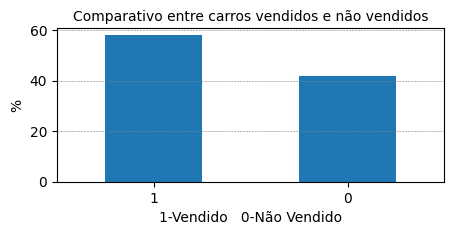

In [10]:
plt.figure(figsize=(5, 2))
plt.title("Comparativo entre carros vendidos e não vendidos", fontsize=10, pad=5)
df_dados.vendido.value_counts(normalize=True).mul(100).plot(kind='bar', rot=0)
plt.grid(axis='y', linestyle='--', linewidth=0.4, color='gray')
plt.xlabel("1-Vendido   0-Não Vendido")
plt.ylabel("%")
plt.show()

Utilizaremos Dummyclassifier com a estratégia 'stratified' - portanto vai chutar o resultado respeitando as proporções

In [11]:
np.random.seed(SEED)

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(X_train, y_train)

acuracia = dummy_stratified.score(X_test, y_test) * 100

print(f'A acurácia do DummyClassifier foi de {acuracia:.2f}%')

A acurácia do DummyClassifier foi de 52.72%


Modelo de árvore de decisão com profundidade 2 para avaliação da acurácia alcançada

In [12]:
np.random.seed(SEED)

tree_classifier = DecisionTreeClassifier(max_depth=2)
tree_classifier.fit(X_train, y_train)

acuracia = tree_classifier.score(X_test, y_test) * 100

print(f'A acurácia do DecisionTreeClassifier foi de {acuracia:.2f}%')

A acurácia do DecisionTreeClassifier foi de 71.92%


A acurácia foi melhor que do modelo dummy, mas o percentual atingido ainda pode ser questionado por não ser muito alto, além disse temos um aleatoriedade relacionado ao seed que dependendo do valor atribuido podemos alcançar valores melhores ou piores. Precisamos de uma precisão maior relacionado a faixa mínima é maxima de acurácia atingida pelo modelo para que tenhamos mais segurança da proporção de acertos que podemos atingir.

### Validação cruzada
Testar o modelo com mais de um conjunto de treino e teste vai permitir encontrar a acurácia do modelo dentro de um intervalo de confiança.

#### Cross Validate
O cross validate divide a base de dados de forma determinística, sem aleatoriedade.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' alt="Como funciona o cross validate" width="600" height="350"> </img>

In [13]:
scores = cross_validate(tree_classifier, X, y, cv=5)

scores

{'fit_time': array([0.02202535, 0.0130024 , 0.04501104, 0.01401043, 0.03499866]),
 'score_time': array([0.00697255, 0.00300241, 0.00298262, 0.00700116, 0.01400447]),
 'test_score': array([0.756 , 0.7565, 0.7625, 0.7545, 0.7595])}

In [14]:
def calcula_intervao_confianca(scores):
    media = scores['test_score'].mean()
    desvio_padrao = scores['test_score'].std()
    intervalo_confiança = ((media-2*desvio_padrao) * 100, (media+2*desvio_padrao) * 100) 

    print(f'A quantidade de splits é de {len(scores["test_score"])} folds')
    print(f'A média dos scores é de {media:.5f}')
    print(f'O desvio padrão é de {desvio_padrao}')
    print(f'O intervalo de confiança ficou entre {intervalo_confiança[0]:.2f}% e {intervalo_confiança[1]:.2f}%')


In [15]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.75780
O desvio padrão é de 0.0028565713714171354
O intervalo de confiança ficou entre 75.21% e 76.35%


Quando utilizamos o cross validate o intervalo de confiança não tem grande impacto com a mudança do seed.

#### KFold
O KFold divide a base de dados com a opção de embaralhamento, de forma aleatória com o parametro shuffle.</br>
Não permite dividir os dados de forma estratificada, podendado causar desbalanceamento das bases de treino e teste.

In [16]:
cv = KFold(n_splits=5, shuffle=True)
scores = cross_validate(tree_classifier, X, y, cv=cv)

scores

{'fit_time': array([0.01599503, 0.02200031, 0.01300073, 0.06100178, 0.07799983]),
 'score_time': array([0.00301218, 0.00400066, 0.00400066, 0.00399733, 0.00400162]),
 'test_score': array([0.7695, 0.7515, 0.7415, 0.7695, 0.7575])}

In [17]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.75790
O desvio padrão é de 0.010762899237658944
O intervalo de confiança ficou entre 73.64% e 77.94%


#### StratifiedKFold
O StratifiedKFold permite dividir a base de dados com embaralhamento e estratificado.</br>
Não permite agrupar por categorias, fazendo com que uma mesma categoria esteja na base de treino e teste.

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_validate(tree_classifier, X, y, cv=cv)

scores

{'fit_time': array([0.01700377, 0.01700449, 0.03000402, 0.02900076, 0.03200006]),
 'score_time': array([0.00699806, 0.00399208, 0.00299215, 0.00300217, 0.0090034 ]),
 'test_score': array([0.744 , 0.77  , 0.7715, 0.7585, 0.745 ])}

In [19]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.75780
O desvio padrão é de 0.011758401251870932
O intervalo de confiança ficou entre 73.43% e 78.13%


#### GroupKFold
É muito importante pensar qual tipo de teste e treino será utilizado, pois se escolhermos um tipo inapropriado, obteremos uma estimativa irreal de como esse estimador funcionará no mundo real.</br>
Precisamos avaliar o modelo para novos carros, o GroupKfold permite fazer o cross validate sem embaralhamento, agrupando por atributo informado.

In [20]:
# Criando a coluna modelo_aleatório - somando um valor randomico entre 1 e 4 a coluna idade_do_modelo
# Isso é, cada ano possui 4 modelos de veículo
df_dados_grupo = df_dados.copy()

df_dados_grupo['modelo_aleatorio'] = np.random.randint(1, 5, size=df_dados.shape[0]) + df_dados_grupo.idade_do_modelo

# Exemplo dos 4 modelos para os carros com 10 anos
df_dados_grupo.query('idade_do_modelo == 10')['modelo_aleatorio'].unique()

array([14, 11, 13, 12], dtype=int64)

In [21]:
df_dados_grupo.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,20
1,40557.96,1,20,12622.05362,21
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,5
4,117384.68,1,4,12770.11290,7


In [22]:
cv = GroupKFold(n_splits=5)
scores = cross_validate(tree_classifier, X, y, cv=cv, groups=df_dados_grupo['modelo_aleatorio'])

scores

{'fit_time': array([0.01799822, 0.01999283, 0.01599956, 0.03400111, 0.08599257]),
 'score_time': array([0.00899911, 0.00300479, 0.03599811, 0.03100085, 0.00499725]),
 'test_score': array([0.74612694, 0.76235647, 0.75543478, 0.77054967, 0.75263952])}

In [23]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.75742
O desvio padrão é de 0.008379550778477036
O intervalo de confiança ficou entre 74.07% e 77.42%


### Avaliação do modelo SCV 
O modelo SVC é sensível a escala, precisamos escalar os dados antes do treino

In [34]:
scaler = StandardScaler()
scaler.fit(X)

X_scaler = scaler.transform(X)

In [35]:
np.random.seed(SEED)
svc = SVC()

cv = GroupKFold(n_splits=5)
scores = cross_validate(svc, X_scaler, y, cv=cv, groups=df_dados_grupo['modelo_aleatorio'])

scores

{'fit_time': array([2.73999763, 2.0109992 , 2.14502382, 2.26634192, 2.15208411]),
 'score_time': array([0.97700143, 0.97300267, 1.21197152, 1.25801373, 1.35094976]),
 'test_score': array([0.75662169, 0.77583625, 0.75197628, 0.77206253, 0.77576672])}

In [36]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.76645
O desvio padrão é de 0.010124104181515357
O intervalo de confiança ficou entre 74.62% e 78.67%


Os dados foram escalados uma vez só para a execução do cross validate.</br>
Na verdade devemos escalar para cada execução do cross validate, o processo precisa ser melhorado.</br>
Com a biblioteca Pipelane podemos rodar o scaler para cada split.

In [38]:
np.random.seed(SEED)

scaler = StandardScaler()
svc = SVC()

pipeline = Pipeline([('Transformador', scaler), ('Estimador', svc)])

cv = GroupKFold(n_splits=5)
scores = cross_validate(pipeline, X, y, cv=cv, groups=df_dados_grupo['modelo_aleatorio'])

scores

{'fit_time': array([2.60169125, 2.10914826, 2.05999851, 2.09499454, 1.98802352]),
 'score_time': array([1.37692881, 1.07556868, 0.97699833, 0.95000553, 0.93897533]),
 'test_score': array([0.75562219, 0.77533699, 0.75247036, 0.77256682, 0.77425842])}

In [39]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 5 folds
A média dos scores é de 0.76605
O desvio padrão é de 0.009891828363514356
O intervalo de confiança ficou entre 74.63% e 78.58%


### Treinando o modelo final
Agora que temos diversas abordagens de validação podemos escolher a que acredita ser ideal para as características dos seus dados, de acordo com o que deseja predizer.</br>

A média e o intervalo providos pela validação cruzada diz o quão bem você espera que o modelo se comporte com dados previamente desconhecidos mas... se você usou cross validation com 10 folds, <b>qual dos 10 modelos treinados você vai usar agora no mundo real?</b></br>

A ideia é que a validação cruzada num conjunto de dados somente te diz o que você pode esperar. Ela não treina o seu modelo final.</br>

Agora você tem o algoritmo do estimador (por exemplo um DecisionTreeClassifier) e pretende usá-lo no mundo real:</br>

Os resultados indicados pela validação cruzada indica o intervalo % de acerto esperado. Para obter o modelo final basta treiná-lo em todos os dados que você usou para o crossvalidation.</br>

Pronto, seu modelo está pronto para ser usado com o predict para classificar etc dados novos.

In [40]:
tree_classifier = DecisionTreeClassifier(max_depth=2)
tree_classifier.fit(X, y)

DecisionTreeClassifier(max_depth=2)